In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

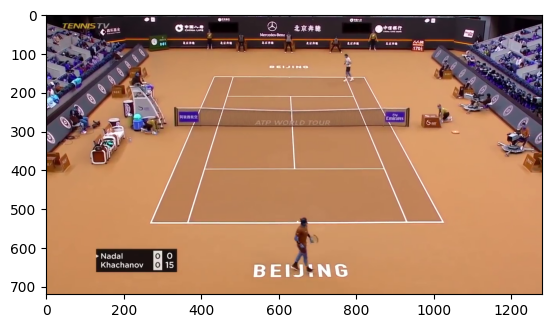

In [2]:
image = cv2.imread('input_image9.png', cv2.IMREAD_COLOR)

plt.imshow(image)
plt.show()

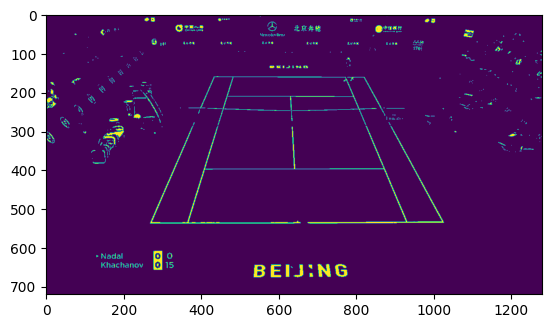

In [3]:
# Converti l'immagine in scala di grigi
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Applica un tresholding all'immagine per trovare le linee del campo
_, binary_image = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

plt.imshow(binary_image)
plt.show()

In [4]:
# Inizializzazione SIFT
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray, None)

In [5]:
# Imposta un treshold per SIFT
threshold = 10
filtered_keypoints = [kp for kp in keypoints if kp.size < threshold]

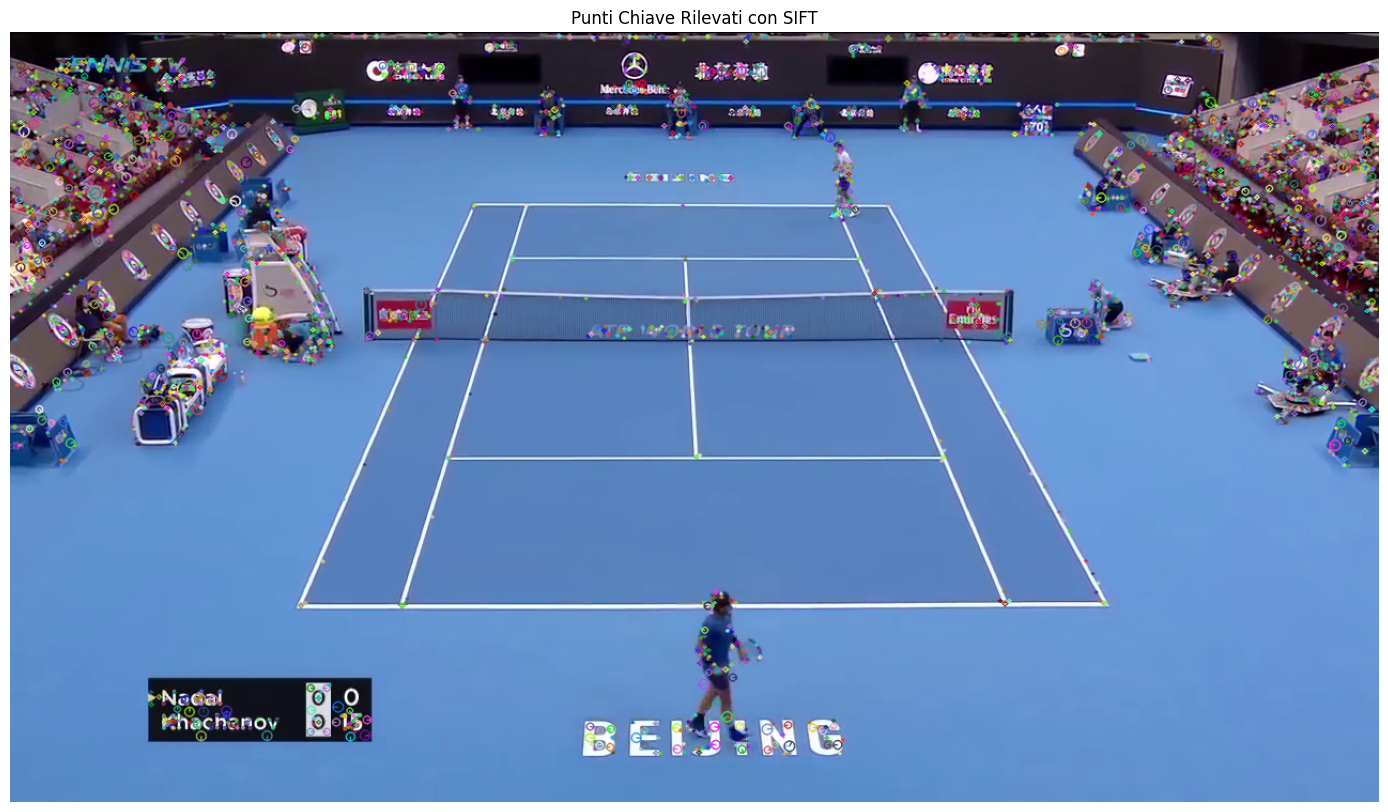

In [6]:
sift_image = cv2.drawKeypoints(image, filtered_keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20, 10))

plt.title('Punti Chiave Rilevati con SIFT')
plt.imshow(cv2.cvtColor(sift_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

(-0.5, 1279.5, 719.5, -0.5)

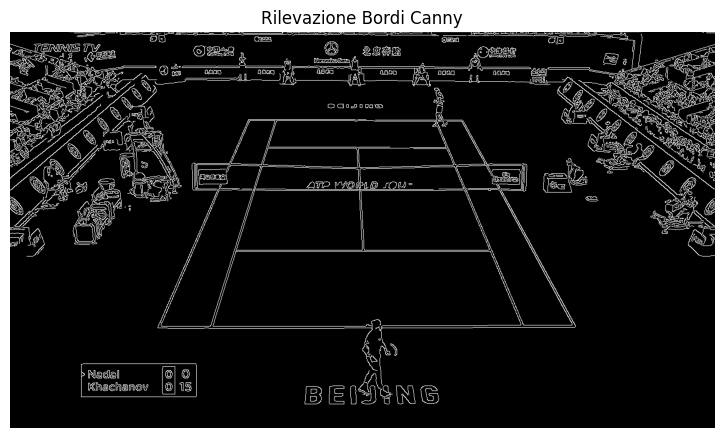

In [8]:
# Trova gli edges con Canny
edges = cv2.Canny(gray, 100, 200)

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 2)
plt.title('Rilevazione Bordi Canny')
plt.imshow(edges, cmap='gray', vmin='0', vmax='255' )
plt.axis('off')

In [9]:
# Trova i contorni
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Seleziona il contorno più grande (assumendo che sia il campo da tennis)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    contour_image = image.copy()
    cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 2)
else:
    largest_contour = []

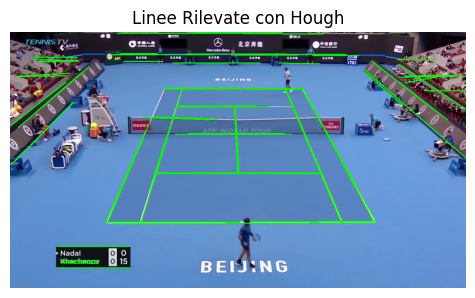

In [10]:
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)
line_image = image.copy()

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 3)
plt.title('Linee Rilevate con Hough')
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

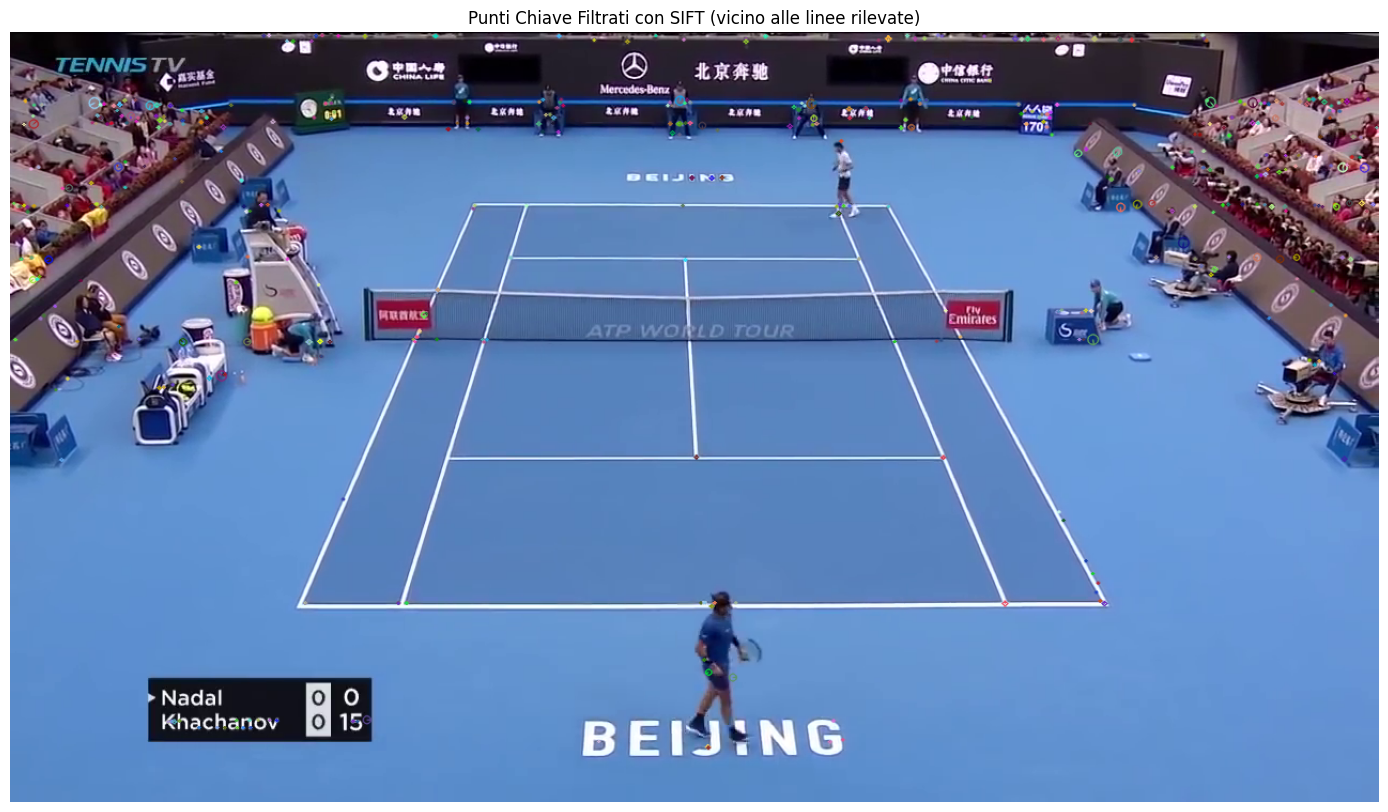

In [11]:
def is_keypoint_near_line(keypoint, lines, threshold=0.5):
    for line in lines:
        x1, y1, x2, y2 = line[0]
        distance = np.abs((y2 - y1) * keypoint.pt[0] - (x2 - x1) * keypoint.pt[1] + x2 * y1 - y2 * x1) / np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        if distance < threshold:
            return True
    return False

filtered_keypoints = [kp for kp in keypoints if is_keypoint_near_line(kp, lines)]
filtered_keypoints = [kp for kp in filtered_keypoints if kp.size < threshold]

sift_image = cv2.drawKeypoints(image, filtered_keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20, 10))

plt.title('Punti Chiave Filtrati con SIFT (vicino alle linee rilevate)')
plt.imshow(cv2.cvtColor(sift_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

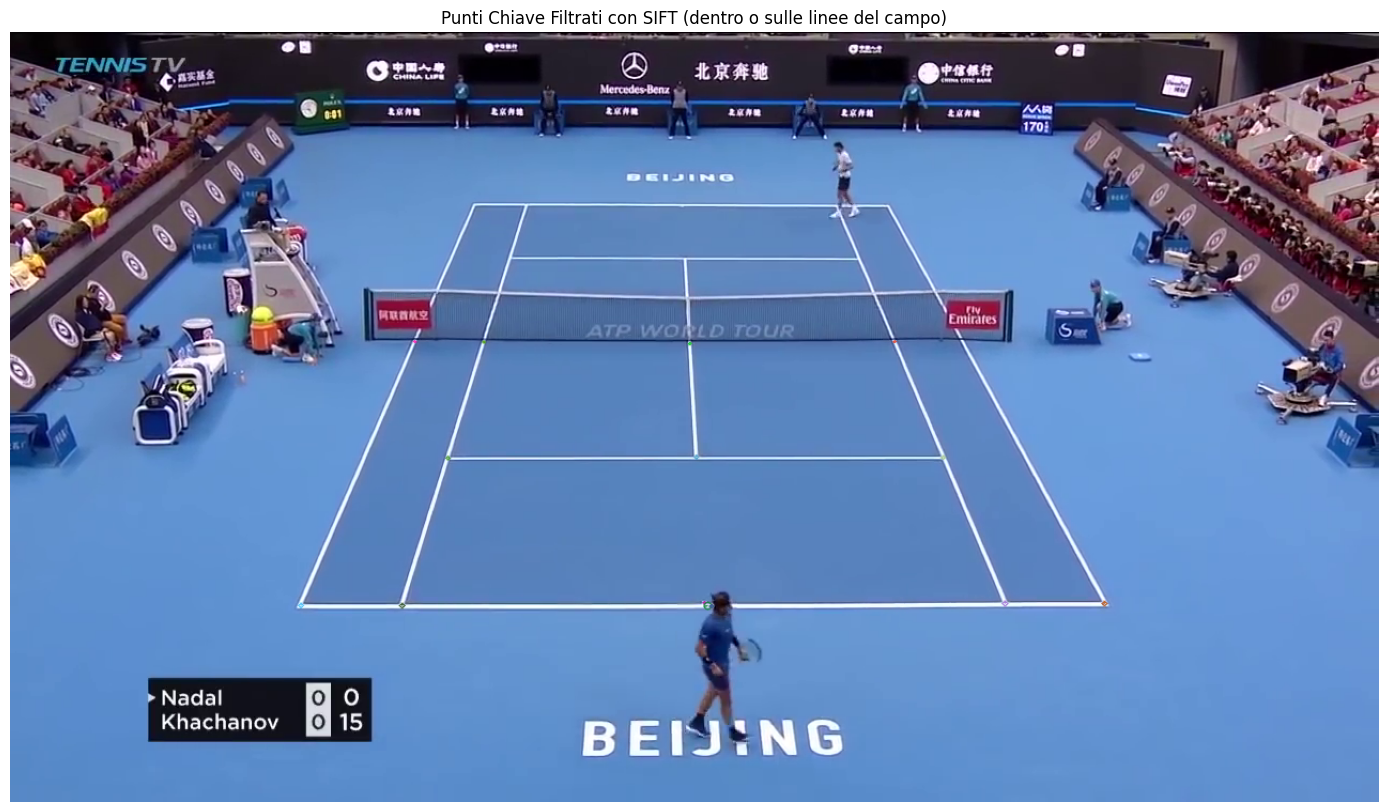

In [14]:
# Ricerca dei keypoints corretti
keypoints_filtered = []
for kp in keypoints:
    x, y = kp.pt
    distance = cv2.pointPolygonTest(largest_contour, (int(x), int(y)), True)
    if distance >= 0:  # Considera solo i punti chiave all'interno o sul contorno
        keypoints_filtered.append(kp)

# Disegna i keypoints
sift_image = cv2.drawKeypoints(image, keypoints_filtered, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20, 10))
plt.title('Punti Chiave Filtrati con SIFT (dentro o sulle linee del campo)')
plt.imshow(cv2.cvtColor(sift_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

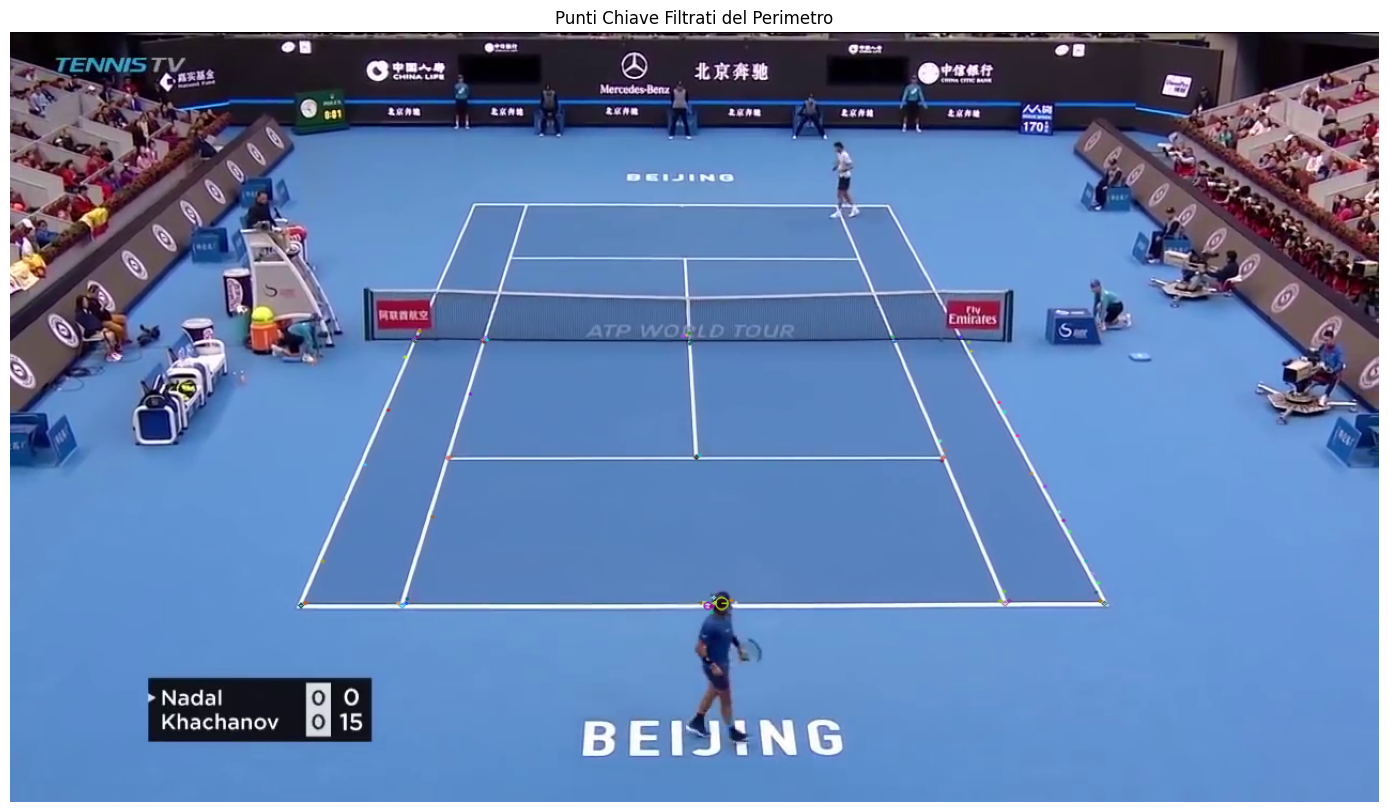

In [15]:
# Trova i contorni
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Seleziona il contorno più grande (assumendo che sia il campo da tennis)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    contour_image = image.copy()
    cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 2)
else:
    largest_contour = None

# Filtra i punti chiave per ottenere solo quelli del perimetro del campo
keypoints_filtered = []
for kp in keypoints:
    x, y = kp.pt
    distance = cv2.pointPolygonTest(largest_contour, (int(x), int(y)), True)
    if distance > -10:  # Considera solo i punti chiave vicini al contorno
        keypoints_filtered.append(kp)

# Disegna i punti chiave filtrati sull'immagine originale
sift_filtered_image = cv2.drawKeypoints(image, keypoints_filtered, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Aumenta la dimensione della figura|
plt.figure(figsize=(20, 10))

# Visualizza i punti chiave filtrati
plt.title('Punti Chiave Filtrati del Perimetro')
plt.imshow(cv2.cvtColor(sift_filtered_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Mostra la figura
plt.show()